In [ ]:
%%bash 
rm -rf /usr/local/cuda 
ln -s /usr/local/cuda-10.1 /usr/local/cuda

# **HW2**
## **Named Entity Recognition**
*deadline*: **25-03-2022 00:30**

You should build your own NER system. You can use all pretrained models except models that trained on our test set. Data for this HW was taken from https://github.com/dialogue-evaluation/factRuEval-2016 and http://bsnlp.cs.helsinki.fi/shared-task.html

Final score will be computed by join competition results https://www.kaggle.com/c/mipt-nlp-hw2-2022 and minimal theory. For the five top places you obtain additional points:

1. 10
2. 8
3. 6
4. 5
5. 4  

All submissions to any task should have your team name.

### Rules
1. Homework is done in a group of up to 3 people. If you are doing a task in a group when sending to anytask, please indicate the logins of the group members so that they can be found in the anytask system.
2. Homework is submitted through anytask, invites will be additionally sent.
3. Homework is made in the form of a report either in a .pdf file, or in an ipython notebook.
4. The report should contain: the numbering of tasks and items that you completed, the solution code, and a clear step-by-step description of what you did. The report should be written in an academic style, without excessive use of slang and in compliance with the norms of the Russian language.
5. Do not copy fragments of lectures, articles and Wikipedia into your report.
Reports consisting solely of code will not be validated and will automatically be scored at zero.
6. Plagiarism and any unfair quotation leads to zeroing of the score.

# Part 1. Analyze and prepare
***
1.  Analyze distribution of labels and draw a plot.
2.  Remove unexcepted labels from data (if it's needed) and describe how (if it's needed).

Download data from Kaggle and unzip to drive directory. 

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/kaggle HW2/mipt-nlp-hw2-2022.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/kaggle HW2")

Read out unziped data.

In [ ]:
train_raw = pd.read_csv("/content/drive/MyDrive/kaggle HW2/train.csv", sep="\t")
test_raw = pd.read_csv("/content/drive/MyDrive/kaggle HW2/test.csv", sep="\t")

Check for NAN values in our datasets.

In [ ]:
train_raw.isna().values.any(), test_raw.isna().values.any(), train_raw.isnull().values.any(), test_raw.isnull().values.any()

(False, False, False, False)

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle HW2/final_data_NER.csv", sep="\t")

## Preprocess text with Natasha library

Installing and importing Natasha

In [ ]:
!pip install natasha

     |████████████████████████████████| 34.4 MB 1.9 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 41 kB 112 kB/s 
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 8.2 MB 32.1 MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=bdcd836362d683b877679a1503f23a069a4eb7ad57b095363034a7f88e6a4ee2
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

Define function for get POS-Tags

In [ ]:
def get_pos(sent):
    doc = Doc(sent)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    res = [word.pos for word in doc.tokens]
    return res


Define function for get word lemms

In [ ]:
def get_lemm(sent):
    doc = Doc(sent)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for i in doc.tokens:
        i.lemmatize(morph_vocab)
    res = [token.lemma for token in doc.tokens]
    return res

Apply our functions to dataset

In [ ]:
train_raw['pos'] = train_raw['text'].apply(get_pos)

In [ ]:
train_raw['sent'] = train_raw['text'].str.split()


In [ ]:
train_raw['lemm'] = train_raw['text'].apply(get_lemm)
train

,labels,text,clf,pos,sent,lemm
0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,"[ADP, NOUN, ADJ, NOUN, ADP, NOUN, NOUN, PROPN,...","[В, понедельник, 28, июня, у, здания, мэрии, М...","[в, понедельник, 28, июнь, у, здание, мэрия, м..."
1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,"[ADP, NOUN, PUNCT, VERB, NOUN, NOUN, PUNCT, PU...","[Среди, требований, ,, выдвигаемых, организато...","[среди, требование, ,, выдвигать, организатор,..."
2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,"[NOUN, NOUN, VERB, VERB, ADP, PRON, NOUN, NOUN...","[Участникам, акции, предлагалось, принести, с,...","[участник, акция, предлагаться, принести, с, с..."
3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,"[NOUN, NOUN, AUX, VERB, ADP, NUM, NOUN, PUNCT,...","[Начало, акции, было, намечено, на, 19, часов,...","[начало, акция, быть, наметить, на, 19, час, ;..."
4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,"[ADJ, NOUN, NOUN, VERB, PUNCT, SCONJ, NOUN, AD...","[Освещающие, акцию, блоггеры, сообщили, ,, что...","[освещать, акция, блогер, сообщить, ,, что, ав..."
...,...,...,...,...,...,...
1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True,"[NOUN, VERB, NOUN, VERB, NOUN, ADP, NOUN]","[Сделка, способствует, укреплений, растущих, с...","[сделка, способствовать, укрепление, расти, св..."
1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False,"[NOUN, PROPN, PROPN, PROPN, CCONJ, ADJ, NOUN, ...","[Председатель, КНР, Ху, Цзиньтао, и, российски...","[председатель, кнр, ху, цзиньтао, и, российски..."
1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False,"[ADJ, NOUN, NOUN, ADV, ADV, VERB, NOUN, PUNCT,...","[Новые, поставки, нефти, почти, вдвое, увелича...","[новый, поставка, нефть, почти, вдвое, увеличи..."
1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False,"[ADP, DET, NOUN, NOUN, ADJ, NOUN, VERB, ADP, A...","[До, сих, пор, доставка, сырой, нефти, осущест...","[до, сей, пора, доставка, сырой, нефть, осущес..."


To make shure that all preparations are correct i've decided to check leghts of our features

In [ ]:
train['text_len'] = train['sent'].str.len()
train['lbs'] = train['labels'].str.split()
train['lb_len'] = train['lbs'].str.len()
train['pos_len'] = train['pos'].str.len()
train['lemm_len'] = train['lemm'].str.len()


In [ ]:
check = train[['lb_len', 'pos_len', 'lemm_len', 'text_len']]
res = check[(check['pos_len'] != check['lemm_len'])]


On that step there were some mismatches because of domain names in text (.РФ, .ru, lenta.ru, etc.) which were tokenized by Natasha as separate words

After all preparations I wroute all new data to a file

In [ ]:
train_raw['pos_str'] = train_raw['pos'].apply(lambda x: ' '.join(map(str, x)))
train_raw['lemm_srt'] = train_raw['lemm'].apply(lambda x: ' '.join(map(str, x)))
train_my = train_raw[["labels", "text", "clf", "pos_str", "lemm_srt"]]
train_my.to_csv('final_data_NER.csv', sep='\t')

## Analyze distribution of labels and draw a plot.

So here is our prepared dataset

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/final_data_NER.csv", sep="\t")

In [ ]:
train_df

,Unnamed: 0,Unnamed: 0.1,labels,text,clf,pos_str,lemm_srt
0,0,0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,ADP NOUN ADJ NOUN ADP NOUN NOUN PROPN ADP ADJ ...,в понедельник 28 июнь у здание мэрия москва на...
1,1,1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,ADP NOUN PUNCT VERB NOUN NOUN PUNCT PUNCT ADJ ...,"среди требование , выдвигать организатор акция..."
2,2,2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,NOUN NOUN VERB VERB ADP PRON NOUN NOUN CCONJ N...,участник акция предлагаться принести с себя ли...
3,3,3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,NOUN NOUN AUX VERB ADP NUM NOUN PUNCT VERB PUN...,начало акция быть наметить на 19 час ; подчерк...
4,4,4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,ADJ NOUN NOUN VERB PUNCT SCONJ NOUN ADP NOUN V...,"освещать акция блогер сообщить , что автобус с..."
...,...,...,...,...,...,...,...
1514,1514,1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True,NOUN VERB NOUN VERB NOUN ADP NOUN,сделка способствовать укрепление расти связь м...
1515,1515,1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False,NOUN PROPN PROPN PROPN CCONJ ADJ NOUN PROPN PR...,председатель кнр ху цзиньтао и российский през...
1516,1516,1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False,ADJ NOUN NOUN ADV ADV VERB NOUN PUNCT ADJ NOUN...,новый поставка нефть почти вдвое увеличить объ...
1517,1517,1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False,ADP DET NOUN NOUN ADJ NOUN VERB ADP ADJ NOUN A...,до сей пора доставка сырой нефть осуществлятьс...


Let's transform out dataset to word-based approach, and encode our sentences

In [ ]:
words = train_df.text.str.split(expand=True).stack()
labels = train_df.labels.str.split(expand=True).stack()
pos = train_df.pos_str.str.split(expand=True).stack()
lemm = train_df.lemm_srt.str.split(expand=True).stack()

train_words_df = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
    'POS': pos.values,
    'Lemm': lemm.values,
})

In [ ]:
train_words_df.head()

,Sentence,Word,Label,POS,Lemm
0,1,В,O,ADP,в
1,1,понедельник,O,NOUN,понедельник
2,1,28,O,ADJ,28
3,1,июня,O,NOUN,июнь
4,1,у,O,ADP,у


Make some preparations to whatch dataset summary later

In [ ]:
word_counts = train_words_df.groupby("Sentence")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
MAX_SENTENCE = word_counts.max()[0]
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
longest_sentence = train_words_df[train_words_df["Sentence"]==longest_sentence_id]["Word"].str.cat(sep=' ')
all_words = list(set(train_words_df["Word"].values))
all_tags = list(set(train_words_df["Label"].values))

In [ ]:
train_labels = [label for sentence in list(map(lambda x: x.split(), train_df.labels)) for label in sentence]

In [ ]:
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
train_label_counter = Counter(train_labels)

In [ ]:
train_words_df['Sentence'].value_counts()

1339    151
1221    133
825      95
906      95
456      86
       ... 
349       1
231       1
1404      1
1406      1
1408      1
Name: Sentence, Length: 1519, dtype: int64

In [ ]:
train_label_counter

Counter({'B_LOC': 888,
         'B_ORG': 727,
         'B_PER': 702,
         'I_LOC': 182,
         'I_ORG': 854,
         'I_PER': 503,
         'O': 25158})

In [ ]:
words = set(list(train_words_df['Word'].values))
#words.add('PADword')
n_words = len(words)
n_words

10183

Join our features to one sentence

In [ ]:
agg_func = lambda s: [(w, t, p, l) for w, t, p, l in zip(s["Word"], s["Label"], train_words_df["POS"].values.tolist(), train_words_df["Lemm"].values.tolist())] #, train_words_df["POS"].values.tolist(), train_words_df["Lemm"].values.tolist()

In [ ]:
data = train_words_df[["Sentence", "Word", "POS", "Label"]]

In [ ]:
grouped = train_words_df.groupby("Sentence").apply(agg_func)


In [ ]:
grouped

Sentence
1       [(В, O, ADP, в), (понедельник, O, NOUN, понеде...
2       [(Среди, O, ADP, в), (требований, O, NOUN, пон...
3       [(Участникам, O, ADP, в), (акции, O, NOUN, пон...
4       [(Начало, O, ADP, в), (акции, O, NOUN, понедел...
5       [(Освещающие, O, ADP, в), (акцию, O, NOUN, пон...
                              ...                        
1515    [(Сделка, O, ADP, в), (способствует, O, NOUN, ...
1516    [(Председатель, O, ADP, в), (КНР, B_LOC, NOUN,...
1517    [(Новые, O, ADP, в), (поставки, O, NOUN, понед...
1518    [(До, O, ADP, в), (сих, O, NOUN, понедельник),...
1519    [(По, O, ADP, в), (договору, O, NOUN, понедель...
Length: 1519, dtype: object

In [ ]:
sentences = [s for s in grouped]


### Plots and dataset summary

Total number of sentences in the dataset: 1,519
Total words in the dataset: 29,014
Number of unique words: 10183
Number of unique tags : 7
Longest sentence in the corpus contains 151 words.
ID of the longest sentence is 1339.
The longest sentence in the corpus is:

Участники турнира • Веселин Топалов ( Болгария , 30 лет , рейтинг — 2801 ) • Вишванатан Ананд ( Индия , 36 , 2792 ) • Левон Аронян ( Армения , 23 , 2752 ) • Петер Леко ( Венгрия , 26 , 2740 ) • Василий Иванчук ( Украина , 36 , 2729 ) • Борис Гельфанд ( Израиль , 37 , 2723 ) • Этьенн Бакро ( Франция , 22 , 2717 ) • Шахрияр Мамедьяров ( Азербайджан , 20 , 2709 ) • Майкл Адамс ( Великобритания , 34 , 2707 ) • Иван Соколов ( Нидеоланды , 37 , 2689 ) • Гата Камский ( США , 31 , 2686 ) • Сергей Тивяков ( Нидерланды , 32 , 2669 ) • Сергей Карякин ( Украина , 15 , 2660 ) • Люк Ван Велли ( Нидерланды , 33 , 2647 ) Средний рейтинг турнира — 2716


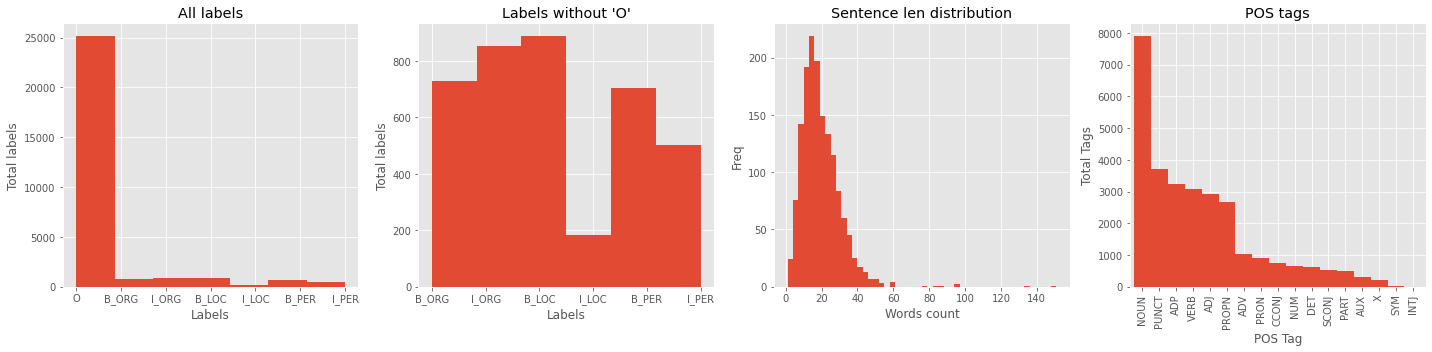

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.style.use("ggplot")

plt.subplot(1, 4, 4)
train_words_df["POS"].value_counts().sort_values(ascending=False).plot(kind = 'bar', width=1)
plt.title("POS tags")
plt.ylabel("Total Tags")
plt.xlabel("POS Tag")

plt.subplot(1, 4, 3)
plt.hist([len(sentence) for sentence in sentences], bins= 50)
plt.title("Sentence len distribution")
plt.ylabel("Freq")
plt.xlabel("Words count")

plt.subplot(1, 4, 2)
plt.hist([key for key, val in train_label_counter.items() for _ in range(val) if key != 'O'], 6)
plt.title("Labels without 'O'")
plt.ylabel("Total labels")
plt.xlabel("Labels")


plt.subplot(1, 4, 1)
plt.hist([key for key, val in train_label_counter.items() for _ in range(val)], 7)
plt.title("All labels")
plt.ylabel("Total labels")
plt.xlabel("Labels")

plt.tight_layout()

print("Total number of sentences in the dataset: {:,}".format(train_df["text"].nunique() + 1))
print("Total words in the dataset: {:,}".format(train_words_df.shape[0]))
print("Number of unique words: {}".format(train_words_df["Word"].nunique()))
print("Number of unique tags : {}".format(train_words_df["Label"].nunique()))
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))
print("ID of the longest sentence is {}.".format(longest_sentence_id))
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

# Part 2. Try a baseline
***
1.  Performe baseline from this tutorial https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html.
2.  Make crossvalidation.
3.  Describe your features and results.

## Features

Let's define some features.  
For the first try we will use word identity, word suffix, word shape, word POS tag, word lemm and word stemms.  
Also, we will use some information from nearby words, and markers for beginning and end of sentence.

In [ ]:
def word2features(sent, i, use_emd=False):

    word = sent[i][0]
    label = sent[i][1]
    pos = sent[i][2]
    lemm = sent[i][3]

    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word[:-1]': word[:-1],
        'word[:-2]': word[:-2],
        'word.pos': pos,
        'word.lemm': lemm
    }
    if use_emd:
      for idx, e in enumerate(model[word]):
        features[f"embedding{idx}"] = e
    if i > 0:
        word1 = sent[i-1][0]
        pos1 = sent[i-1][2]
        lemm1 = sent[i-1][3]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.pos': pos1,
            '-1:word.lemm': lemm1
        })
        for idx, e in enumerate(model[word1]):
            features[f"-1:embedding{idx}"] = e
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        pos1 = sent[i+1][2]
        lemm1 = sent[i+1][3]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.pos': pos1,
            '+1:word.lemm': lemm1
        })
        for idx, e in enumerate(model[word1]):
            features[f"+1:embedding{idx}"] = e
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent, use_emd=False):
    return [word2features(sent, i, use_emd=use_emd) for i in range(len(sent))]

Sentence example

In [ ]:
grouped.iloc[0]

[('В', 'O', 'ADP', 'в'),
 ('понедельник', 'O', 'NOUN', 'понедельник'),
 ('28', 'O', 'ADJ', '28'),
 ('июня', 'O', 'NOUN', 'июнь'),
 ('у', 'O', 'ADP', 'у'),
 ('здания', 'O', 'NOUN', 'здание'),
 ('мэрии', 'B_ORG', 'NOUN', 'мэрия'),
 ('Москвы', 'I_ORG', 'PROPN', 'москва'),
 ('на', 'O', 'ADP', 'на'),
 ('Тверской', 'B_LOC', 'ADJ', 'тверской'),
 ('площади', 'I_LOC', 'NOUN', 'площадь'),
 ('состоялась', 'O', 'VERB', 'состояться'),
 ('очередная', 'O', 'ADJ', 'очередной'),
 ('несанкционированная', 'O', 'ADJ', 'несанкционированный'),
 ('акция', 'O', 'NOUN', 'акция'),
 ('протеста', 'O', 'NOUN', 'протест'),
 ('«', 'O', 'PUNCT', '«'),
 ('День', 'O', 'NOUN', 'день'),
 ('гнева', 'O', 'NOUN', 'гнев'),
 ('»', 'O', 'PUNCT', '»'),
 (',', 'O', 'PUNCT', ','),
 ('в', 'O', 'ADP', 'в'),
 ('этот', 'O', 'DET', 'этот'),
 ('раз', 'O', 'NOUN', 'раз'),
 ('направленная', 'O', 'VERB', 'направить'),
 (',', 'O', 'PUNCT', ','),
 ('главным', 'O', 'ADJ', 'главный'),
 ('образом', 'O', 'NOUN', 'образ'),
 (',', 'O', 'PUNCT', '

This is what word2features extracts:

In [ ]:
sent2features(grouped.iloc[0], use_emd=False)[0]

{'+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lemm': 'понедельник',
 '+1:word.lower()': 'понедельник',
 '+1:word.pos': 'NOUN',
 'BOS': True,
 'bias': 1.0,
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': True,
 'word.lemm': 'в',
 'word.lower()': 'в',
 'word.pos': 'ADP',
 'word[-2:]': 'В',
 'word[-3:]': 'В',
 'word[:-1]': '',
 'word[:-2]': ''}

Get our labels for training part:

In [ ]:
def sent2labels(sent):
    return [label for token, label, postag, lemm in sent]

In [ ]:
from sklearn.model_selection import train_test_split

Extract features from the data:

In [ ]:
X = [sent2features(s) for s in grouped]
Y = [sent2labels(s) for s in grouped]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Training

For the first try we will not use word embendings, just pre-install models

In [ ]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextskipgram_300_5_2018.tgz

--2022-03-21 11:41:02--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextskipgram_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659449819 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextskipgram_300_5_2018.tgz’

m_none_fasttextskip   2%[                    ]  71.63M  19.8MB/s    eta 2m 44s ^C


In [ ]:
!tar -xzf araneum_none_fasttextskipgram_300_5_2018.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
!pip install sklearn-crfsuite==0.3.6

In [ ]:
!pip install -U 'scikit-learn<0.24'

In [ ]:
%load_ext autoreload
%autoreload 2


import sys
import warnings


warnings.filterwarnings("ignore")

In [ ]:
import gensim

In [ ]:
model = gensim.models.KeyedVectors.load('araneum_none_fasttextskipgram_300_5_2018.model')

In [ ]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 2.99 s, sys: 13.8 ms, total: 3 s
Wall time: 3.12 s


## Evaluation

First, let's look at our classes:

In [ ]:
labels = list(crf.classes_)
labels

['O', 'B_LOC', 'B_ORG', 'I_LOC', 'I_ORG', 'B_PER', 'I_PER']

And some model score:

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.944003937422749

Inspect per-class results in more detail:

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      0.971     0.989     0.980      8271
       B_LOC      0.858     0.821     0.839       301
       I_LOC      0.688     0.361     0.473        61
       B_ORG      0.764     0.508     0.610       242
       I_ORG      0.630     0.456     0.529       250
       B_PER      0.784     0.825     0.804       251
       I_PER      0.793     0.931     0.856       189

    accuracy                          0.948      9565
   macro avg      0.784     0.699     0.727      9565
weighted avg      0.943     0.948     0.944      9565



There is much more 'O' entities in data set, but we’re more interested in other entities.  
To account for this we’ll use averaged F1 score computed for all labels except for 'O'. 

In [ ]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B_LOC', 'B_ORG', 'I_LOC', 'I_ORG', 'B_PER', 'I_PER']

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7147819650625025

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B_LOC      0.858     0.821     0.839       301
       I_LOC      0.688     0.361     0.473        61
       B_ORG      0.764     0.508     0.610       242
       I_ORG      0.630     0.456     0.529       250
       B_PER      0.784     0.825     0.804       251
       I_PER      0.793     0.931     0.856       189

   micro avg      0.774     0.687     0.728      1294
   macro avg      0.753     0.650     0.685      1294
weighted avg      0.764     0.687     0.715      1294



## Hyperparameter Optimization
To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.5min finished


CPU times: user 7min 57s, sys: 1.23 s, total: 7min 58s
Wall time: 8min 31s


Summary of our best results:

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.011527652233033548, 'c2': 0.07634581193247741}
best CV score: 0.6733123978128884
model size: 1.18M


## Check parameter space

Dark blue => 0.5201, dark red => 0.6733


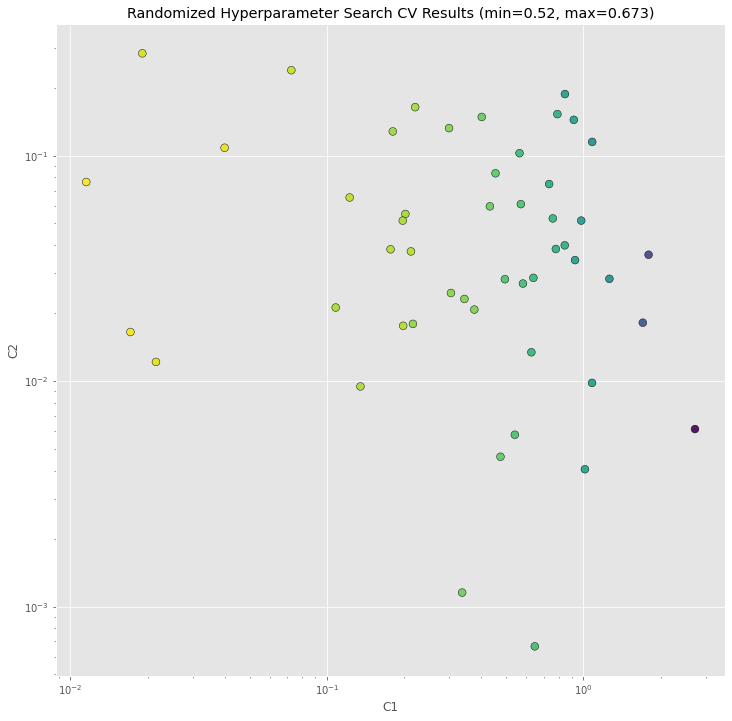

In [ ]:
_x = [s for s in rs.cv_results_['param_c1']]
_y = [s for s in rs.cv_results_['param_c2']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B_LOC      0.854     0.817     0.835       301
       I_LOC      0.724     0.344     0.467        61
       B_ORG      0.748     0.504     0.602       242
       I_ORG      0.558     0.444     0.494       250
       B_PER      0.807     0.817     0.812       251
       I_PER      0.817     0.921     0.866       189

   micro avg      0.767     0.679     0.720      1294
   macro avg      0.751     0.641     0.679      1294
weighted avg      0.756     0.679     0.708      1294



In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I_ORG  -> I_ORG   4.646943
B_PER  -> I_PER   4.446108
I_LOC  -> I_LOC   4.309321
B_LOC  -> I_LOC   3.960532
B_ORG  -> I_ORG   3.942018
O      -> O       2.589932
I_PER  -> I_PER   2.281932
O      -> B_LOC   1.757114
O      -> B_ORG   1.736972
O      -> B_PER   0.895809
I_ORG  -> B_PER   0.362818
B_LOC  -> B_PER   0.011154
B_LOC  -> O       -0.077967
I_PER  -> B_ORG   -0.142304
I_LOC  -> B_PER   -0.174913
B_PER  -> O       -0.241930
I_LOC  -> B_ORG   -0.370130
I_PER  -> O       -0.424477
I_PER  -> I_LOC   -0.538541
I_LOC  -> O       -0.560790

Top unlikely transitions:
I_ORG  -> O       -0.979075
I_LOC  -> I_PER   -1.036123
B_ORG  -> I_LOC   -1.040046
B_PER  -> B_LOC   -1.066792
B_PER  -> B_ORG   -1.088951
I_ORG  -> I_PER   -1.132455
I_PER  -> I_ORG   -1.134923
B_ORG  -> I_PER   -1.195590
I_ORG  -> I_LOC   -1.220115
B_ORG  -> B_LOC   -1.386373
B_PER  -> I_ORG   -1.437796
I_ORG  -> B_LOC   -1.510096
I_PER  -> B_PER   -1.539409
B_LOC  -> I_PER   -1.887919
B_LOC  ->

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
3.260244 O        -1:word.lower():»
3.152593 B_PER    word.istitle()
3.014604 B_ORG    word.isupper()
2.941250 B_LOC    -1:word.lower():в
2.909889 O        -1:word.lower():«
2.613639 B_LOC    -1:word.lower():вашем
2.524807 O        bias
2.506439 I_PER    word.istitle()
2.406698 B_LOC    word.istitle()
2.360227 B_PER    word[-2:]:ин
2.326501 B_ORG    -1:word.lower():глава
2.305557 B_LOC    -1:word.lower():на
2.292133 B_ORG    word[:-2]:сборн
2.277558 B_ORG    word[-3:]:.ru
2.277558 B_ORG    word[-2:]:ru
2.258475 B_ORG    -1:word.lower():сообщает
2.167237 O        BOS
2.158794 O        +1:word.lemm:понедельник
2.041944 B_LOC    word[-2:]:ии
2.013699 O        word[:-2]:
2.009933 O        EOS
2.004950 B_ORG    +1:word.lower():заявляет
1.994943 B_PER    +1:word.lower():сказал
1.973869 O        word[:-1]:
1.950167 I_PER    -1:word.istitle()
1.914495 B_ORG    +1:word.lower():собирается
1.910012 B_PER    word[-3:]:нко
1.892117 B_ORG    +1:word.lower():пообещали
1.889406 B_PER    

# Part 3. Try your favorite ML algorithm.
***
1. Make submission to leaderboard and beat with your favorite ML algorithm (0.55 macro f1).
2. Plot learning curves (if your algo is not rule-based).
3. Describe your solution (or one of your solutions) and results. Also here your can do many experiments.

  
I've decided to use BertForTokenClassification. Model has BERT as its base architecture, with a token classification head on top. NER is typically treated as a token classification problem.

## Installs

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import os

## Dataset preprocess

Here is our dataset.  
I will use my preprocessed file from first part of the HW.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/final_data_NER.csv", sep="\t")

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,labels,text,clf,pos_str,lemm_srt
0,0,0,0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,ADP NOUN ADJ NOUN ADP NOUN NOUN PROPN ADP ADJ ...,в понедельник 28 июнь у здание мэрия москва на...
1,1,1,1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,ADP NOUN PUNCT VERB NOUN NOUN PUNCT PUNCT ADJ ...,"среди требование , выдвигать организатор акция..."
2,2,2,2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,NOUN NOUN VERB VERB ADP PRON NOUN NOUN CCONJ N...,участник акция предлагаться принести с себя ли...
3,3,3,3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,NOUN NOUN AUX VERB ADP NUM NOUN PUNCT VERB PUN...,начало акция быть наметить на 19 час ; подчерк...
4,4,4,4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,ADJ NOUN NOUN VERB PUNCT SCONJ NOUN ADP NOUN V...,"освещать акция блогер сообщить , что автобус с..."


In [ ]:
data.shape

(1519, 8)

In [ ]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'labels', 'text', 'clf',
       'pos_str', 'lemm_srt'],
      dtype='object')

Here is some legacy parts of code from first tries.

In [ ]:
words = data.text.str.split(expand=True).stack()
labels = data.labels.str.split(expand=True).stack()
pos = data.pos_str.str.split(expand=True).stack()
lemm = data.lemm_srt.str.split(expand=True).stack()

data = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
    'POS': pos.values,
    'Lemm': lemm.values,
})
data.head(3)

,Sentence,Word,Label,POS,Lemm
0,1,В,O,ADP,в
1,1,понедельник,O,NOUN,понедельник
2,1,28,O,ADJ,28


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentence'] = data[['Sentence','Word','Label']].groupby(['Sentence'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['word_labels'] = data[['Sentence','Word','Label']].groupby(['Sentence'])['Label'].transform(lambda x: ','.join(x))
data.head(3)

,Sentence,Word,Label,POS,Lemm,sentence,word_labels
0,1,В,O,ADP,в,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
1,1,понедельник,O,NOUN,понедельник,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
2,1,28,O,ADJ,28,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."


Let's only keep the "sentence" and "word_labels" columns, and drop duplicates:

In [ ]:
data = data[["Sentence", "sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
data.head()

,Sentence,sentence,word_labels
0,1,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
1,2,"Среди требований , выдвигаемых организаторами ...","O,O,O,O,O,O,O,O,O,O,O,B_LOC,B_PER,I_PER,O,O,O,..."
2,3,Участникам акции предлагалось принести с собой...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_PER,..."
3,4,Начало акции было намечено на 19 часов ; подчё...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,5,"Освещающие акцию блоггеры сообщили , что автоб...","O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC,O,..."


While examing Sklearn documentation, I've found some interesting for my Class for encoding labels.  
Despite the fact that I already numerated my sentences, let's try this Class.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_df = data
data_df["Sentence #"] = LabelEncoder().fit_transform(data["Sentence"])
data_df

,Sentence,sentence,word_labels,Sentence #
0,1,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,...",0
1,2,"Среди требований , выдвигаемых организаторами ...","O,O,O,O,O,O,O,O,O,O,O,B_LOC,B_PER,I_PER,O,O,O,...",1
2,3,Участникам акции предлагалось принести с собой...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_PER,...",2
3,4,Начало акции было намечено на 19 часов ; подчё...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O",3
4,5,"Освещающие акцию блоггеры сообщили , что автоб...","O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC,O,...",4
...,...,...,...,...
1514,1515,Сделка способствует укреплений растущих связей...,"O,O,O,O,O,O,O",1514
1515,1516,Председатель КНР Ху Цзиньтао и российский през...,"O,B_LOC,B_PER,I_PER,O,O,O,B_PER,I_PER,O,O,O,O,...",1515
1516,1517,Новые поставки нефти почти вдвое увеличат объе...,"O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,O,B_LOC",1516
1517,1518,До сих пор доставка сырой нефти осуществлялись...,"O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC",1517


In [ ]:
data_df = data_df[["Sentence #", "sentence", "word_labels"]]
data_df.head()

,Sentence #,sentence,word_labels
0,0,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
1,1,"Среди требований , выдвигаемых организаторами ...","O,O,O,O,O,O,O,O,O,O,O,B_LOC,B_PER,I_PER,O,O,O,..."
2,2,Участникам акции предлагалось принести с собой...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_PER,..."
3,3,Начало акции было намечено на 19 часов ; подчё...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,4,"Освещающие акцию блоггеры сообщили , что автоб...","O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC,O,..."


## Augmentation

Here we are tring to add some data for LOC labels, using synonims.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/final_data_NER.csv", sep="\t")

In [ ]:
s = train_df[train_df['labels'].str.contains("I_LOC")]

In [ ]:
words = s.text.str.split(expand=True).stack()
labels = s.labels.str.split(expand=True).stack()

train_words_df = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
})

In [ ]:
train_words_df

,Sentence,Word,Label
0,1,В,O
1,1,понедельник,O
2,1,28,O
3,1,июня,O
4,1,у,O
...,...,...,...
2710,1518,дороге,O
2711,1518,в,O
2712,1518,тихоокеанский,B_LOC
2713,1518,порт,I_LOC


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"], s["Label"])] #, train_words_df["POS"].values.tolist(), train_words_df["Lemm"].values.tolist()

In [ ]:
grouped = train_words_df.groupby("Sentence").apply(agg_func)


In [ ]:
import re
import gensim
import logging
import nltk.data 
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
urllib.request.urlretrieve(
    "http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", 
    "ruscorpora_mystem_cbow_300_2_2015.bin.gz"
)

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f1178060490>)

In [ ]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 7.3 MB/s 
     |████████████████████████████████| 7.1 MB 4.3 MB/s 


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
new_sents = []

In [ ]:


for i in grouped:
    print(i)
    err = 0
    for n, item in enumerate(i):
        if item[1] == 'I_LOC': # моджно поменять на B_loc
            print(item[0])
            #print(n)
            p = morph.parse(item[0])[0]
            pos = p.tag.POS
            if pos:    
                if pos == "ADJF": # в локах бывают "", союзы и английские слова, с этим траблы
                      pos = "_A"
                else:
                      pos = "_S"
                case = p.tag.case
                try:
                    syn_ten = model_ru.most_similar(positive=[f'{p.normal_form}{pos}'], topn=10)
                except KeyError:
                    err = 1
                #print(err)
                if not err:
                    syn = []
                    for w, fr in syn_ten:
                        syn.append(w[:-2])
                    print(syn)
                    comp = []
                    for s in syn:
                        p_s = morph.parse(s)[0]
                        #print(p_s[0])
                        try:
                            c_s = p_s.inflect({"loct"})[0] # тут тоже ошибка если не в словаре слово
                        except: TypeError
                        comp.append((c_s, item[1]))
                    #print(comp)
                    if comp:
                        #for c in comp:
                        n_i = i
                        n_i[n] = random.choice(comp)
                        #print(n_i)
                        #new_sents.append(n_i)
                        #n_i = i
            
                pass
    new_sents.append(i)

[('В', 'O'), ('понедельник', 'O'), ('28', 'O'), ('июня', 'O'), ('у', 'O'), ('здания', 'O'), ('мэрии', 'B_ORG'), ('Москвы', 'I_ORG'), ('на', 'O'), ('Тверской', 'B_LOC'), ('площади', 'I_LOC'), ('состоялась', 'O'), ('очередная', 'O'), ('несанкционированная', 'O'), ('акция', 'O'), ('протеста', 'O'), ('«', 'O'), ('День', 'O'), ('гнева', 'O'), ('»', 'O'), (',', 'O'), ('в', 'O'), ('этот', 'O'), ('раз', 'O'), ('направленная', 'O'), (',', 'O'), ('главным', 'O'), ('образом', 'O'), (',', 'O'), ('против', 'O'), ('политики', 'O'), ('московских', 'O'), ('и', 'O'), ('подмосковных', 'O'), ('властей', 'O')]
площади
['сквер', 'улица', 'бульвар', 'переулок', 'парк', 'пресня', 'набережная', 'проспект', 'здание', 'пустырь']
[('Освещающие', 'O'), ('акцию', 'O'), ('блоггеры', 'O'), ('сообщили', 'O'), (',', 'O'), ('что', 'O'), ('автобусы', 'O'), ('с', 'O'), ('милицией', 'O'), ('стали', 'O'), ('занимать', 'O'), ('площадь', 'O'), ('у', 'O'), ('памятника', 'B_LOC'), ('Юрию', 'I_LOC'), ('Долгорукому', 'I_LOC'), (

In [ ]:
clean_sent = []
clean_tags = []
for i in new_sents:
    words = []
    tags = []
    for w, t in i:
        words.append(w)
        tags.append(t)
    clean_sent.append(words)
    clean_tags.append(tags)

In [ ]:
join_new = []
for i in clean_sent:
    join_new.append(" ".join(i))

In [ ]:
join_tags = []
for i in clean_tags:
    join_tags.append(" ".join(i))

In [ ]:
data = pd.DataFrame(join_new)

In [ ]:
data2 = pd.DataFrame(join_tags)

In [ ]:
data['tags'] = data2[0]

In [ ]:
data["len_words"] = data[0].str.split().apply(len)
data["len_tags"] = data['tags'].str.split().apply(len)

In [ ]:
data.to_csv("aug_I_LOC_last.csv", sep="\t")

In [ ]:
data.head(50)

,0,tags,len_words,len_tags
0,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,35,35
1,"Освещающие акцию блоггеры сообщили , что автоб...",O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,27,27
2,Барак Обама принимает в Белом квартире своего ...,B_PER I_PER O O B_LOC I_LOC O O O B_PER I_PER,11,11
3,"В частности , лидеры намерены обменяться мнени...",O O O O O O O O O O O B_ORG O B_LOC O O O B_LO...,24,24
4,В понедельник Джаред Лофнер в наручниках и в с...,O O B_PER I_PER O O O O O O O O O O O B_LOC I_LOC,17,17
5,"Тогда были убиты шесть человек , а член Палаты...",O O O O O O O O B_ORG I_ORG I_ORG I_ORG O B_LO...,27,27
6,Обама выступал в Белом хате через несколько ча...,B_PER O O B_LOC I_LOC O O O O O O O O O O O O ...,24,24
7,Президент и первая леди Мишель Обама задержали...,O O O O B_PER I_PER O O B_LOC I_LOC O O O O O ...,19,19
8,"В тот же день Южная вьетнаме заявила , что вся...",O O O O B_LOC I_LOC O O O O O O B_LOC O O O O ...,25,25
9,До сих пор среди главных стратегических партнё...,O O O O O O O O B_LOC O O O O O O O O B_LOC I_...,25,25


In [ ]:
aug = pd.read_csv("/content/drive/MyDrive/kaggle HW2/aug_I_LOC_last.csv", sep="\t")

In [ ]:
aug["word_labels"] = aug.tags.str.split().apply(",".join)

In [ ]:
aug = aug[["Unnamed: 0", "0", "word_labels"]]

In [ ]:
aug = aug.rename(columns={"Unnamed: 0": "Sentence #", "0": "sentence", "word_labels": "word_labels"})

In [ ]:
result = pd.concat([data_df, aug], ignore_index=True, sort=False)

In [ ]:
data_df = result

In [ ]:
data_df

,Sentence #,sentence,word_labels
0,0,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
1,1,"Среди требований , выдвигаемых организаторами ...","O,O,O,O,O,O,O,O,O,O,O,B_LOC,B_PER,I_PER,O,O,O,..."
2,2,Участникам акции предлагалось принести с собой...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_PER,..."
3,3,Начало акции было намечено на 19 часов ; подчё...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,4,"Освещающие акцию блоггеры сообщили , что автоб...","O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC,O,..."
...,...,...,...
2644,1125,На заре первого дня Нового года нефть начали к...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,..."
2645,1126,На заре первого дня Нового года нефть начали к...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,..."
2646,1127,На заре первого дня Нового года нефть начали к...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,..."
2647,1128,На заре первого дня Нового года нефть начали к...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,..."


## Preparing the dataset and dataloader

Here are imports, most of them are from legacy tries with different mosels and tokenizers.

In [ ]:
#from transformers import RobertaTokenizerFast, RobertaForTokenClassification
from torch.utils.data import Dataset, DataLoader
import pdb
import torch
from torch import cuda
from sklearn.metrics import accuracy_score
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM,  AutoModelForTokenClassification

Creating config dictionary for our model training and evaluating variables.  
Theese params are from very last attempt.
I've decided to use huge max lenght and small batch size.  
This time GPU was avaliable and I've set epochs to 20, all previous attemts I was using 1, 3, 5, or 15.  
We will use PyTorch tensors that we provide to our model.

In [ ]:
config = {#'model_name': "DeepPavlov/rubert-base-cased",
         'max_length': 512,
         'train_batch_size':8,
         'valid_batch_size':16,
         'epochs':20,
         'learning_rate':1e-05,
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

In [ ]:
config = {#'model_name': "DeepPavlov/rubert-base-cased",
         'max_length': 300,
         'train_batch_size':16,
         'valid_batch_size':16,
         'epochs':30,
         'learning_rate':1e-05,
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

Some secondary dict comprehensions for converting str labels to nums.

In [ ]:
output_labels = {'B_LOC': 3,
 'B_ORG': 1,
 'B_PER': 5,
 'I_LOC': 4,
 'I_ORG': 2,
 'I_PER': 6,
 'O': 0}

labels_to_ids = {v:k for k,v in enumerate(output_labels)}
ids_to_labels = {k:v for k,v in enumerate(output_labels)}

In [ ]:
print(f"Labels to ID ==> {labels_to_ids}\nID to Labels ==> {ids_to_labels}")

Labels to ID ==> {'B_LOC': 0, 'B_ORG': 1, 'B_PER': 2, 'I_LOC': 3, 'I_ORG': 4, 'I_PER': 5, 'O': 6}
ID to Labels ==> {0: 'B_LOC', 1: 'B_ORG', 2: 'B_PER', 3: 'I_LOC', 4: 'I_ORG', 5: 'I_PER', 6: 'O'}


Here is my most problem in that task.  
NER with BERT relies on wordpiece tokenization, rather than word tokenization. So we should also define the labels at the wordpiece-level.

1. First approach train the model on the tag labels for the first word piece token of a word. I found discussion about that problem on [GitHub](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).

2. Second approach is to propagate the original label of the word to all of its word pieces. I saw it in NER tutorial with BERT.  

3. Third approach is to give the first wordpiece original word label, and then use the label “X” for all subsequent subwords.  
***

About my PyTorch dataset class.  
* Tokenized each sentence;
* Special BERT tokens add;
* PAD tokens or truncat based on the max length of the model;
* Attention mask creation;
* Create labels;
* Get rid of Word-pieces(tag them with "-100" default ignore_index of PyTorch's CrossEntropyLoss).


In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",")


        # We'll use offsets_mapping" for individual tokens
        encoding = self.tokenizer(
                             text=sentence,
                             add_special_tokens=True,
                             pad_to_max_length=True,
                             return_attention_mask = True, 
                             #return_tensors = 'pt',  # off because we need some custom steps before
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=self.max_len)
                           
        
        labels = [labels_to_ids[label] for label in word_labels] 

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] != 0 and mapping[0] != encoding['offset_mapping'][idx-1][1]:
                try:
                    encoded_labels[idx] = labels[i]
                except:
                    pass
                i += 1
            else:
                if idx==1:
                    encoded_labels[idx] = labels[i]
                    i += 1

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Legacy implementation of second aproach to wordpiece problem:

In [ ]:
def tokenize_worpieces(sentence, text_labels, tokenizer):

    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

Try to remove sub-tokens from sentences:

In [ ]:
def original_length(sentence, tags):
   words = []
   words_tags = []
   for index, token in enumerate(tokenizer.tokenize(sentence)):
       if token.startswith("##"):
           if words:
               words[-1] = f"{words[-1]}{token[2:]}"
       else:
           words.append(token)
           words_tags.append(tags[index])
   return words_tags, words

Let's define our tokenizer and model.
My best results were on "DeepPavlov" pretrained model, so I leave it as main for me.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")  #("sberbank-ai/bert-base-NER-reptile-5-datasets")
model = AutoModelForTokenClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=len(output_labels))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initializ

In [ ]:
#v = tokenizer.get_vocab()
#print(len(v))
tokenizer.add_tokens(["лента.ру", "lenta.ru", ".рф", "Кремль.рф"])
#v = tokenizer.get_vocab()
#print(len(v))

4

Create 2 datasets, one for training and one for testing.
That is the one of the last tries, so I'm not using part of train dataset fot evaluation.

In [ ]:
data = data_df[['sentence', 'word_labels']]
train_size = 1
train_dataset = data.sample(frac=train_size,random_state=300)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, config['max_length'])
testing_set = dataset(test_dataset, tokenizer, config['max_length'])

FULL Dataset: (2649, 2)
TRAIN Dataset: (2649, 2)
TEST Dataset: (0, 2)


Define PyTorch dataloaders:

In [ ]:
train_params = {'batch_size': config['train_batch_size'],
                'shuffle': True,
                'num_workers': 12,
                'pin_memory':True
                }

test_params = {'batch_size': config['valid_batch_size'],
                'shuffle': True,
                'num_workers': 1,
                'pin_memory':True
                }

training_loader = DataLoader(training_set, **train_params)
#testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training

In [ ]:
device = config['device']

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

Perform a sanity check.  
Found that part form [Andrej Karpathy's](http://karpathy.github.io/2019/04/25/recipe/):

In [ ]:
model.to(device)
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
               return_dict=False)
initial_loss = outputs[0]
initial_loss

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor(2.2858, device='cuda:0', grad_fn=<NllLossBackward0>)

Define optimizer. I will use Adam.

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config['learning_rate'])

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 1e-05, eps = 1e-05)

Define training function:

In [ ]:

def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                               return_dict=False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           

        flattened_targets = labels.view(-1)
        active_logits = tr_logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)
        

        active_accuracy = labels.view(-1) != -100
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['max_grad_norm']
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    return epoch_loss, tr_accuracy

In [ ]:
for epoch in range(config['epochs']):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 2.142857551574707
Training loss per 100 training steps: 0.5869576957556281
Training loss epoch: 0.4213719781353531
Training accuracy epoch: 0.8786288937960338
Training epoch: 2


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.07570414245128632
Training loss per 100 training steps: 0.0692364245394964
Training loss epoch: 0.059170164246426286
Training accuracy epoch: 0.9867749639998461
Training epoch: 3


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.033516671508550644
Training loss per 100 training steps: 0.026701452205935033
Training loss epoch: 0.027839212930839824
Training accuracy epoch: 0.9934227990264338
Training epoch: 4


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.008107129484415054
Training loss per 100 training steps: 0.01635831383766957
Training loss epoch: 0.016972627445875882
Training accuracy epoch: 0.9962467240993684
Training epoch: 5


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.005596899427473545
Training loss per 100 training steps: 0.008514431659086137
Training loss epoch: 0.009971523923232747
Training accuracy epoch: 0.9979124835529326
Training epoch: 6


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0030499459244310856
Training loss per 100 training steps: 0.009503750026797746
Training loss epoch: 0.009653655840196165
Training accuracy epoch: 0.9976486521217408
Training epoch: 7


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.00204307003878057
Training loss per 100 training steps: 0.005708410087650144
Training loss epoch: 0.006079365228266309
Training accuracy epoch: 0.998549260309445
Training epoch: 8


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0012975574936717749
Training loss per 100 training steps: 0.0038592338891663028
Training loss epoch: 0.004296842350271048
Training accuracy epoch: 0.9990953873132994
Training epoch: 9


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0010179186938330531
Training loss per 100 training steps: 0.00312651463526089
Training loss epoch: 0.003762679398957505
Training accuracy epoch: 0.9991335175338618
Training epoch: 10


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.001095602405257523
Training loss per 100 training steps: 0.0031758587102009225
Training loss epoch: 0.0030651621314337902
Training accuracy epoch: 0.9994056684391236
Training epoch: 11


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0012318568769842386
Training loss per 100 training steps: 0.002409905872980852
Training loss epoch: 0.0021562416629630128
Training accuracy epoch: 0.999626453554027
Training epoch: 12


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0008079393301159143
Training loss per 100 training steps: 0.0014346922804845848
Training loss epoch: 0.0012665615576257683
Training accuracy epoch: 0.9997390265911325
Training epoch: 13


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.000515105202794075
Training loss per 100 training steps: 0.0016764144152103195
Training loss epoch: 0.002153503906307181
Training accuracy epoch: 0.9994194962375754
Training epoch: 14


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.003394161118194461
Training loss per 100 training steps: 0.0021703727696077103
Training loss epoch: 0.0022878940048885635
Training accuracy epoch: 0.9994693483005728
Training epoch: 15


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0007221511332318187
Training loss per 100 training steps: 0.0014621642280466818
Training loss epoch: 0.0012818266816804725
Training accuracy epoch: 0.9997461586101973
Training epoch: 16


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0004776123387273401
Training loss per 100 training steps: 0.0012350942628886919
Training loss epoch: 0.001302669531348756
Training accuracy epoch: 0.9997402899371767
Training epoch: 17


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.0006849098717793822
Training loss per 100 training steps: 0.0018276977081930653
Training loss epoch: 0.0015021323111379541
Training accuracy epoch: 0.9997792638834755
Training epoch: 18


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.00046599950292147696
Training loss per 100 training steps: 0.001348892081872385
Training loss epoch: 0.0013037331194367193
Training accuracy epoch: 0.9997144204151251
Training epoch: 19


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training loss per 100 training steps: 0.00038463855162262917


In [ ]:
loss_values = []
accuracies = []

In [ ]:
for epoch in range(config['epochs']):
    print(f"Training epoch: {epoch + 1}")
    epoch_loss,tr_accuracy =  train(epoch)
    loss_values.append(epoch_loss)
    accuracies.append(tr_accuracy)

Training epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 2.0693516731262207
Training loss per 100 training steps: 0.5981796979904175
Training loss epoch: 0.43251976523413715
Training accuracy epoch: 0.8760758379784107
Training epoch: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.06934680789709091
Training loss per 100 training steps: 0.06839838203522239
Training loss epoch: 0.05977083123232945
Training accuracy epoch: 0.9855307465329314
Training epoch: 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.012506060302257538
Training loss per 100 training steps: 0.023693597170127794
Training loss epoch: 0.024376734311367016
Training accuracy epoch: 0.9942736438403661
Training epoch: 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.004397862125188112
Training loss per 100 training steps: 0.015010371241755414
Training loss epoch: 0.015104289069850311
Training accuracy epoch: 0.9962865958970354
Training epoch: 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.031136149540543556
Training loss per 100 training steps: 0.010094946189230253
Training loss epoch: 0.010187975880661867
Training accuracy epoch: 0.9976298676051717
Training epoch: 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.007388858124613762
Training loss per 100 training steps: 0.006702840740857001
Training loss epoch: 0.007847577963916427
Training accuracy epoch: 0.9980455894863535
Training epoch: 7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0028694209177047014
Training loss per 100 training steps: 0.00483088498522463
Training loss epoch: 0.005122346743234399
Training accuracy epoch: 0.9988793929730554
Training epoch: 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0013701057760044932
Training loss per 100 training steps: 0.006055873174377081
Training loss epoch: 0.005670291106202583
Training accuracy epoch: 0.9988267527173135
Training epoch: 9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.008607875555753708
Training loss per 100 training steps: 0.004206501259261023
Training loss epoch: 0.004625726830991299
Training accuracy epoch: 0.9990922326942233
Training epoch: 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.02879457361996174
Training loss per 100 training steps: 0.003238685978322963
Training loss epoch: 0.0035256846062418253
Training accuracy epoch: 0.9992671510195006
Training epoch: 11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0008091614581644535
Training loss per 100 training steps: 0.002223868531032032
Training loss epoch: 0.0020036753735165618
Training accuracy epoch: 0.9997364362163385
Training epoch: 12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0014063733397051692
Training loss per 100 training steps: 0.0017711114389637468
Training loss epoch: 0.0018290051517528426
Training accuracy epoch: 0.9996735886637029
Training epoch: 13


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0003627391124609858
Training loss per 100 training steps: 0.0013820694570457286
Training loss epoch: 0.001270617123101333
Training accuracy epoch: 0.9997881629585449
Training epoch: 14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00047057316987775266
Training loss per 100 training steps: 0.0006570631818555407
Training loss epoch: 0.0007679700840570325
Training accuracy epoch: 0.9999038794039387
Training epoch: 15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00038015752215869725
Training loss per 100 training steps: 0.0014479443105859773
Training loss epoch: 0.0013880392493391186
Training accuracy epoch: 0.9997062210279722
Training epoch: 16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00033261990756727755
Training loss per 100 training steps: 0.0016682479893074067
Training loss epoch: 0.001813911555506042
Training accuracy epoch: 0.9995646763591785
Training epoch: 17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.02699955925345421
Training loss per 100 training steps: 0.001630095115201179
Training loss epoch: 0.0016164649232341178
Training accuracy epoch: 0.9996097117454276
Training epoch: 18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0005031801993027329
Training loss per 100 training steps: 0.000967228710236452
Training loss epoch: 0.0008624007888397774
Training accuracy epoch: 0.9998083655927499
Training epoch: 19


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00029619017732329667
Training loss per 100 training steps: 0.0006590041147238381
Training loss epoch: 0.0006120303261419197
Training accuracy epoch: 0.9999176341242355
Training epoch: 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00033778726356104016
Training loss per 100 training steps: 0.0009227801368763154
Training loss epoch: 0.0012211944414015174
Training accuracy epoch: 0.9997083930129431
Training epoch: 21


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.047631651163101196
Training loss per 100 training steps: 0.002344596767504146
Training loss epoch: 0.002357884568087925
Training accuracy epoch: 0.9993884164013079
Training epoch: 22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0005888501764275134
Training loss per 100 training steps: 0.000988919175250714
Training loss epoch: 0.0009343663693569791
Training accuracy epoch: 0.999819251267043
Training epoch: 23


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00040885619819164276
Training loss per 100 training steps: 0.0010429899662670835
Training loss epoch: 0.0014998680434725527
Training accuracy epoch: 0.9996736658210643
Training epoch: 24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00029570472543127835
Training loss per 100 training steps: 0.002884106932866092
Training loss epoch: 0.002046217308071139
Training accuracy epoch: 0.9994983254786052
Training epoch: 25


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00027435473748482764
Training loss per 100 training steps: 0.0007236668620187107
Training loss epoch: 0.0005952661267218057
Training accuracy epoch: 0.9998123096581215
Training epoch: 26


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00021494242537301034
Training loss per 100 training steps: 0.0007990364734219424
Training loss epoch: 0.0007677176055226318
Training accuracy epoch: 0.9998276005748317
Training epoch: 27


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00016681330453138798
Training loss per 100 training steps: 0.0008980918449169892
Training loss epoch: 0.0008868896772352844
Training accuracy epoch: 0.999852877453913
Training epoch: 28


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.00025006523355841637
Training loss per 100 training steps: 0.001100345579261827
Training loss epoch: 0.0011054190557382732
Training accuracy epoch: 0.9997671369234887
Training epoch: 29


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.001253685331903398
Training loss per 100 training steps: 0.00113993421822814
Training loss epoch: 0.0011378392330490064
Training accuracy epoch: 0.9996531912146578
Training epoch: 30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/p

Training loss per 100 training steps: 0.0015457600820809603
Training loss per 100 training steps: 0.0011696905374012905
Training loss epoch: 0.0008474284040858038
Training accuracy epoch: 0.9998380040104198


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

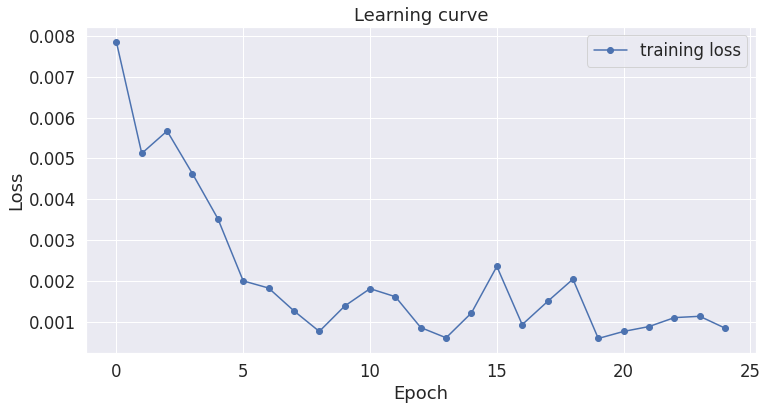

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values[5:], 'b-o', label="training loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

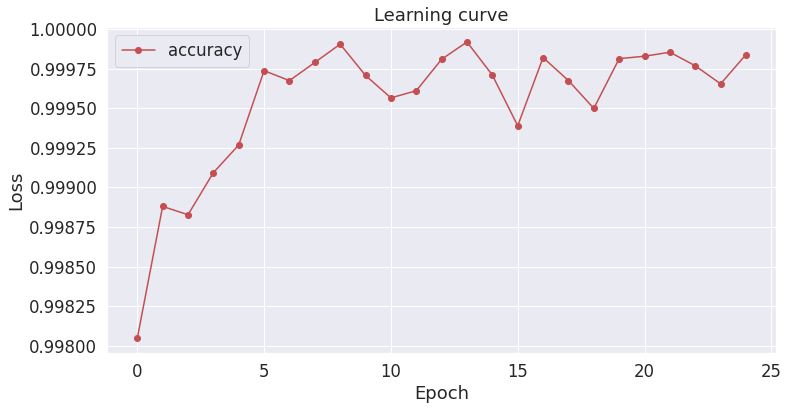

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(accuracies[5:], 'r-o', label="accuracy")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Validation

In [ ]:
def valid(model, testing_loader):
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                                     return_dict=False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            flattened_targets = labels.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            

            active_accuracy = labels.view(-1) != -100
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

Nice accuracy, but we know that we have lots of "O" labels:

In [ ]:
labels, predictions = valid(model, testing_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation loss per 100 evaluation steps: 0.038575027137994766
Validation Loss: 0.0726628828989832
Validation Accuracy: 0.9767107205138064


In [ ]:
valid_df = pd.DataFrame(predictions, index = np.arange(len(labels)), columns=['pred'])
valid_true_df = pd.DataFrame(labels, index = np.arange(len(labels)), columns=['true'])

In [ ]:
freqs_pred = valid_df.pred.value_counts()
freqs_true = valid_true_df.true.value_counts()
freqs_pred, freqs_true

(O        5177
 B_LOC     204
 I_ORG     169
 B_ORG     138
 B_PER     129
 I_PER      88
 I_LOC      26
 Name: pred, dtype: int64, O        5157
 B_LOC     201
 I_ORG     183
 B_ORG     137
 B_PER     126
 I_PER      85
 I_LOC      42
 Name: true, dtype: int64)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


Some metrics:

In [ ]:
f1_score(labels, predictions, average='macro')

0.8640048567884966

In [ ]:
cm = confusion_matrix(labels, predictions, labels=['B_LOC', 'B_ORG', 'B_PER', 'I_LOC', 'I_ORG', 'I_PER', 'O'])

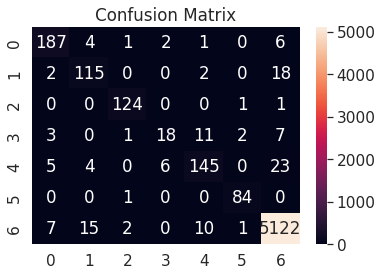

<Figure size 720x504 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

ax= plt.subplot()
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
sn.heatmap(cm, annot=True, fmt='g', ax=ax)

By label perfomance:

In [ ]:
a = classification_report(labels, predictions, target_names=['B_LOC', 'B_ORG', 'B_PER', 'I_LOC', 'I_ORG', 'I_PER', 'O'])
print(a)

              precision    recall  f1-score   support

       B_LOC       0.92      0.93      0.92       201
       B_ORG       0.83      0.84      0.84       137
       B_PER       0.96      0.98      0.97       126
       I_LOC       0.69      0.43      0.53        42
       I_ORG       0.86      0.79      0.82       183
       I_PER       0.95      0.99      0.97        85
           O       0.99      0.99      0.99      5157

    accuracy                           0.98      5931
   macro avg       0.89      0.85      0.86      5931
weighted avg       0.98      0.98      0.98      5931



## Inference

So, lets define inference function and get our submission.

In [ ]:
model.eval()
def inference(sentence):
    inputs = tokenizer(sentence,
#                         is_split_into_words=True, 
                        return_offsets_mapping=True, 
                        padding='max_length', 
                        truncation=True, 
                        max_length=config['max_length'],
                        return_tensors="pt")

    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    outputs = model(ids, attention_mask=mask, return_dict=False)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1)

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions))

    prediction = []
    out_str = []
    off_list = inputs["offset_mapping"].squeeze().tolist()
    for idx, mapping in enumerate(off_list):


#         only predictions on first word pieces are important
        if mapping[0] != 0 and mapping[0] != off_list[idx-1][1]:
            prediction.append(wp_preds[idx][1])
            out_str.append(wp_preds[idx][0])
        else:
            if idx == 1:
                prediction.append(wp_preds[idx][1])
                out_str.append(wp_preds[idx][0])
            continue
    return prediction, out_str

Reading our test data:

In [ ]:
test_texts = pd.read_csv("/content/drive/MyDrive/kaggle HW2/test.csv", sep="\t")

In [ ]:
test_texts

,text,clf
0,Александр Вертинский,False
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False
2,Слишком много « пустого » пространства,True
3,И он научился заполнять его вымыслом,True
4,Создал собственный театр с безумным множеством...,True
...,...,...
2709,"В частности , мы исключили большинство эксперт...",True
2710,"На наш взгляд , это очень важно , особенно , у...",True
2711,"Также один из законов , который принят в этом ...",False
2712,Там соответственно тоже все поручения выполнены,True


In [ ]:
test_texts['predict'] = test_texts['text'].apply(inference)

In [ ]:
df3 = pd.DataFrame(test_texts['predict'].to_list(), columns=['pred_labels','pred_words'])

Let's look at our predictions:

In [ ]:
df3

,pred_labels,pred_words
0,"[B_PER, I_PER]","[Александр, Верт]"
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[«, Я, не, знаю, ,, зачем, и, кому, это, нужно..."
2,"[O, O, O, O, O, O]","[Слишком, много, «, пустого, », пространства]"
3,"[O, O, O, O, O, O]","[И, он, научился, заполня, его, вымы]"
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Создал, собственный, театр, с, безум, множест..."
...,...,...
2709,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[В, частности, ,, мы, исключили, большинство, ..."
2710,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[На, наш, взгляд, ,, это, очень, важно, ,, осо..."
2711,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Также, один, из, законов, ,, который, принят,..."
2712,"[O, O, O, O, O, O]","[Там, соответственно, тоже, все, поручения, вы..."


## Preprocessing for kaggle submission

In [ ]:
test_texts['predicted_labels'] = df3['pred_labels']
#test_texts['predicted_words'] = df3['pred_labels']

In [ ]:
test_texts

,text,clf,predict,predicted_labels
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]"
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]"
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]"
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]"


In [ ]:
test_texts['lbs_len'] = test_texts['predicted_labels'].str.len()
test_texts['st_text'] = test_texts['text'].str.split()
test_texts['st_len'] = test_texts['st_text'].str.len()
#train['lb_len'] = train['lbs'].str.len()
#train['pos_len'] = train['pos'].str.len()
#train['lemm_len'] = train['lemm'].str.len()

In [ ]:
test_texts

,text,clf,predict,predicted_labels,lbs_len,st_text,st_len
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28
...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6


In [ ]:
test_texts['preds_str'] = test_texts['predicted_labels'].apply(" ".join)

In [ ]:
test_texts

,text,clf,predict,predicted_labels,lbs_len,st_text,st_len,preds_str
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2,B_PER I_PER
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6,O O O O O O
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6,O O O O O O
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25,O O O O O O O O O O O O O O O O O O O O O O O O O
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23,O O O O O O O O O O O O O O O O O O O O O O O
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6,O O O O O O


In [ ]:
words = test_texts.text.str.split(expand=True).stack()
labels = test_texts.preds_str.str.split(expand=True).stack()

s = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
})
s.head(5)


,Sentence,Word,Label
0,1,Александр,B_PER
1,1,Вертинский,I_PER
2,2,«,O
3,2,Я,O
4,2,не,O


In [ ]:
s.to_csv("my_submission.csv", sep="\t")

In [ ]:
test_texts['len_labels'] = test_texts['predicted_labels'].str.len()

In [ ]:
test_texts['word_sent'] = test_texts['text'].str.split()

In [ ]:
test_texts['len_sentence'] = test_texts['word_sent'].str.len()
test_texts

,text,clf,predict,predicted_labels,lbs_len,st_text,st_len,preds_str,len_labels,word_sent,len_sentence
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2,B_PER I_PER,2,"[Александр, Вертинский]",2
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46,O O O O O O O O O O O O O O O O O O O O O O O ...,46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6,O O O O O O,6,"[Слишком, много, «, пустого, », пространства]",6
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6,O O O O O O,6,"[И, он, научился, заполнять, его, вымыслом]",6
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28,O O O O O O O O O O O O O O O O O O O O O O O ...,28,"[Создал, собственный, театр, с, безумным, множ...",28
...,...,...,...,...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25,O O O O O O O O O O O O O O O O O O O O O O O O O,25,"[В, частности, ,, мы, исключили, большинство, ...",25
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23,O O O O O O O O O O O O O O O O O O O O O O O,23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28,O O O O O O O O O O O O O O O O O O O O O O O ...,28,"[Также, один, из, законов, ,, который, принят,...",28
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6,O O O O O O,6,"[Там, соответственно, тоже, все, поручения, вы...",6


In [ ]:
res = test_texts[(test_texts['len_sentence'] != test_texts['len_labels'])]

In [ ]:
res

,text,clf,predict,predicted_labels,len_labels,word_sent,len_sentence


In [ ]:
test_texts['str_pred_labels'] = test_texts['predicted_labels'].apply(" ".join)

In [ ]:
test_texts

,text,clf,predict,predicted_labels,lbs_len,st_text,st_len,preds_str,len_labels,word_sent,len_sentence,str_pred_labels
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2,B_PER I_PER,2,"[Александр, Вертинский]",2,B_PER I_PER
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46,O O O O O O O O O O O O O O O O O O O O O O O ...,46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6,O O O O O O,6,"[Слишком, много, «, пустого, », пространства]",6,O O O O O O
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6,O O O O O O,6,"[И, он, научился, заполнять, его, вымыслом]",6,O O O O O O
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28,O O O O O O O O O O O O O O O O O O O O O O O ...,28,"[Создал, собственный, театр, с, безумным, множ...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25,O O O O O O O O O O O O O O O O O O O O O O O O O,25,"[В, частности, ,, мы, исключили, большинство, ...",25,O O O O O O O O O O O O O O O O O O O O O O O O O
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23,O O O O O O O O O O O O O O O O O O O O O O O,23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23,O O O O O O O O O O O O O O O O O O O O O O O
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28,O O O O O O O O O O O O O O O O O O O O O O O ...,28,"[Также, один, из, законов, ,, который, принят,...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6,O O O O O O,6,"[Там, соответственно, тоже, все, поручения, вы...",6,O O O O O O


Define encode function for submission.

In [ ]:
def encode(sentence):
    labels_dict = {
    'O': 1,
    'B_ORG': 2,
    'I_ORG': 3,
    'B_LOC': 4,
    'I_LOC': 5,
    'B_PER': 6,
    'I_PER': 7
}
    return labels_dict[sentence]

In [ ]:
sub = pd.read_csv("my_submission.csv", sep="\t")
sub['Predicted'] = sub['Label'].apply(encode)
sub

,Unnamed: 0,Sentence,Word,Label,Predicted
0,0,1,Александр,B_PER,6
1,1,1,Вертинский,I_PER,7
2,2,2,«,O,1
3,3,2,Я,O,1
4,4,2,не,O,1
...,...,...,...,...,...
56404,56404,2714,В,B_PER,6
56405,56405,2714,.,I_PER,7
56406,56406,2714,Путин,I_PER,7
56407,56407,2714,:,O,1


In [ ]:
my_submission_alfa = sub['Predicted']

In [ ]:
my_submission_alfa

0        6
1        7
2        1
3        1
4        1
        ..
56404    6
56405    7
56406    7
56407    1
56408    1
Name: Predicted, Length: 56409, dtype: int64

In [ ]:
my_submission_alfa.to_csv("sample_submission_eps.csv", sep=",", index_label="Id")


In [ ]:
test = pd.read_csv("/content/sample_submission.csv", sep=",")

In [ ]:
test

,Id,Predicted
0,0,6
1,1,7
2,2,1
3,3,1
4,4,1
...,...,...
56404,56404,6
56405,56405,7
56406,56406,7
56407,56407,1


## Legacy code

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                                     return_dict=False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation loss per 100 evaluation steps: 0.038575027137994766
Validation Loss: 0.0726628828989832
Validation Accuracy: 0.9767107205138064


In [ ]:
valid_df = pd.DataFrame(predictions, index = np.arange(len(labels)), columns=['pred'])
valid_true_df = pd.DataFrame(labels, index = np.arange(len(labels)), columns=['true'])

In [ ]:
valid_df

,pred
0,O
1,O
2,B_PER
3,O
4,O
...,...
5926,O
5927,O
5928,O
5929,B_PER


In [ ]:
freqs_pred = valid_df.pred.value_counts()
freqs_true = valid_true_df.true.value_counts()
freqs_pred, freqs_true

(O        5177
 B_LOC     204
 I_ORG     169
 B_ORG     138
 B_PER     129
 I_PER      88
 I_LOC      26
 Name: pred, dtype: int64, O        5157
 B_LOC     201
 I_ORG     183
 B_ORG     137
 B_PER     126
 I_PER      85
 I_LOC      42
 Name: true, dtype: int64)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [ ]:
f1_score(labels, predictions, average='macro')

0.8640048567884966

In [ ]:
cm = confusion_matrix(labels, predictions, labels=['B_LOC', 'B_ORG', 'B_PER', 'I_LOC', 'I_ORG', 'I_PER', 'O'])

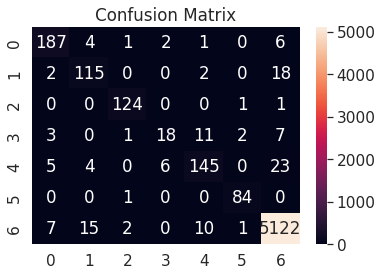

<Figure size 720x504 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

ax= plt.subplot()
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
sn.heatmap(cm, annot=True, fmt='g', ax=ax)

In [ ]:
a = classification_report(labels, predictions, target_names=['B_LOC', 'B_ORG', 'B_PER', 'I_LOC', 'I_ORG', 'I_PER', 'O'])
print(a)

              precision    recall  f1-score   support

       B_LOC       0.92      0.93      0.92       201
       B_ORG       0.83      0.84      0.84       137
       B_PER       0.96      0.98      0.97       126
       I_LOC       0.69      0.43      0.53        42
       I_ORG       0.86      0.79      0.82       183
       I_PER       0.95      0.99      0.97        85
           O       0.99      0.99      0.99      5157

    accuracy                           0.98      5931
   macro avg       0.89      0.85      0.86      5931
weighted avg       0.98      0.98      0.98      5931



In [ ]:
#sentence = "Николай вчера был в Москве"
model.eval()
def inference(sentence):
    inputs = tokenizer(sentence,
#                         is_split_into_words=True, 
                        return_offsets_mapping=True, 
                        padding='max_length', 
                        truncation=True, 
                        max_length=config['max_length'],
                        return_tensors="pt")

    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask, return_dict=False)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

    prediction = []
    out_str = []
    off_list = inputs["offset_mapping"].squeeze().tolist()
    for idx, mapping in enumerate(off_list):
#         print(mapping, token_pred[1], token_pred[0],"####")

#         only predictions on first word pieces are important
        if mapping[0] != 0 and mapping[0] != off_list[idx-1][1]:
#             print(mapping, token_pred[1], token_pred[0])
            prediction.append(wp_preds[idx][1])
            out_str.append(wp_preds[idx][0])
        else:
            if idx == 1:
                prediction.append(wp_preds[idx][1])
                out_str.append(wp_preds[idx][0])
            continue
    return prediction, out_str

In [ ]:
test_texts = pd.read_csv("/content/drive/MyDrive/kaggle HW2/test.csv", sep="\t")

In [ ]:
test_texts

,text,clf
0,Александр Вертинский,False
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False
2,Слишком много « пустого » пространства,True
3,И он научился заполнять его вымыслом,True
4,Создал собственный театр с безумным множеством...,True
...,...,...
2709,"В частности , мы исключили большинство эксперт...",True
2710,"На наш взгляд , это очень важно , особенно , у...",True
2711,"Также один из законов , который принят в этом ...",False
2712,Там соответственно тоже все поручения выполнены,True


In [ ]:
test_texts['predict'] = test_texts['text'].apply(inference)

In [ ]:
df3 = pd.DataFrame(test_texts['predict'].to_list(), columns=['pred_labels','pred_words'])

In [ ]:
df3

,pred_labels,pred_words
0,"[B_PER, I_PER]","[Александр, Верт]"
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[«, Я, не, знаю, ,, зачем, и, кому, это, нужно..."
2,"[O, O, O, O, O, O]","[Слишком, много, «, пустого, », пространства]"
3,"[O, O, O, O, O, O]","[И, он, научился, заполня, его, вымы]"
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Создал, собственный, театр, с, безум, множест..."
...,...,...
2709,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[В, частности, ,, мы, исключили, большинство, ..."
2710,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[На, наш, взгляд, ,, это, очень, важно, ,, осо..."
2711,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Также, один, из, законов, ,, который, принят,..."
2712,"[O, O, O, O, O, O]","[Там, соответственно, тоже, все, поручения, вы..."


In [ ]:
test_texts['predicted_labels'] = df3['pred_labels'].apply(" ".join)

In [ ]:
test_texts

,text,clf,predict,predicted_labels
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])",B_PER I_PER
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",O O O O O O O O O O O O O O O O O O O O O O O ...
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...",O O O O O O
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...",O O O O O O
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",O O O O O O O O O O O O O O O O O O O O O O O O O
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",O O O O O O O O O O O O O O O O O O O O O O O
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",O O O O O O O O O O O O O O O O O O O O O O O ...
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...",O O O O O O


In [ ]:
words = test_texts.text.str.split(expand=True).stack()
labels = test_texts.predicted_labels.str.split(expand=True).stack()

s = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
})
s.head(5)
frequencies = s.Label.value_counts()
frequencies

O        49708
B_ORG     1621
I_ORG     1528
B_PER     1309
B_LOC     1206
I_PER      810
I_LOC      227
Name: Label, dtype: int64

In [ ]:
s.head(5)

,Sentence,Word,Label
0,1,Александр,B_PER
1,1,Вертинский,I_PER
2,2,«,O
3,2,Я,O
4,2,не,O


In [ ]:
s.to_csv("my_submission.csv", sep="\t")

In [ ]:
test_texts['len_labels'] = test_texts['predicted_labels'].str.len()

In [ ]:
test_texts['word_sent'] = test_texts['text'].str.split()

In [ ]:
test_texts['len_sentence'] = test_texts['word_sent'].str.len()
test_texts

,text,clf,predict,predicted_labels,len_labels,word_sent,len_sentence
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28
...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6


In [ ]:
res = test_texts[(test_texts['len_sentence'] != test_texts['len_labels'])]

In [ ]:
res

,text,clf,predict,predicted_labels,len_labels,word_sent,len_sentence


In [ ]:
test_texts['str_pred_labels'] = test_texts['predicted_labels'].apply(" ".join)

In [ ]:
test_texts

,text,clf,predict,predicted_labels,len_labels,word_sent,len_sentence,str_pred_labels
0,Александр Вертинский,False,"([B_PER, I_PER], [Александр, Верт])","[B_PER, I_PER]",2,"[Александр, Вертинский]",2,B_PER I_PER
1,"« Я не знаю , зачем и кому это нужно … » 21 ма...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",46,"[«, Я, не, знаю, ,, зачем, и, кому, это, нужно...",46,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Слишком много « пустого » пространства,True,"([O, O, O, O, O, O], [Слишком, много, «, пусто...","[O, O, O, O, O, O]",6,"[Слишком, много, «, пустого, », пространства]",6,O O O O O O
3,И он научился заполнять его вымыслом,True,"([O, O, O, O, O, O], [И, он, научился, заполня...","[O, O, O, O, O, O]",6,"[И, он, научился, заполнять, его, вымыслом]",6,O O O O O O
4,Создал собственный театр с безумным множеством...,True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Создал, собственный, театр, с, безумным, множ...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...,...,...,...,...,...,...
2709,"В частности , мы исключили большинство эксперт...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",25,"[В, частности, ,, мы, исключили, большинство, ...",25,O O O O O O O O O O O O O O O O O O O O O O O O O
2710,"На наш взгляд , это очень важно , особенно , у...",True,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",23,"[На, наш, взгляд, ,, это, очень, важно, ,, осо...",23,O O O O O O O O O O O O O O O O O O O O O O O
2711,"Также один из законов , который принят в этом ...",False,"([O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",28,"[Также, один, из, законов, ,, который, принят,...",28,O O O O O O O O O O O O O O O O O O O O O O O ...
2712,Там соответственно тоже все поручения выполнены,True,"([O, O, O, O, O, O], [Там, соответственно, тож...","[O, O, O, O, O, O]",6,"[Там, соответственно, тоже, все, поручения, вы...",6,O O O O O O


In [ ]:
def encode(sentence):
    labels_dict = {
    'O': 1,
    'B_ORG': 2,
    'I_ORG': 3,
    'B_LOC': 4,
    'I_LOC': 5,
    'B_PER': 6,
    'I_PER': 7
}
    return labels_dict[sentence]

In [ ]:
sub = pd.read_csv("/content/my_submission.csv", sep="\t")
sub['Predicted'] = sub['Label'].apply(encode)
sub

,Unnamed: 0,Sentence,Word,Label,Predicted
0,0,1,Александр,B_PER,6
1,1,1,Вертинский,I_PER,7
2,2,2,«,O,1
3,3,2,Я,O,1
4,4,2,не,O,1
...,...,...,...,...,...
56404,56404,2714,В,B_PER,6
56405,56405,2714,.,I_PER,7
56406,56406,2714,Путин,I_PER,7
56407,56407,2714,:,O,1


In [ ]:
my_submission_alfa = sub['Predicted']

In [ ]:
my_submission_alfa

0        6
1        7
2        1
3        1
4        1
        ..
56404    6
56405    7
56406    7
56407    1
56408    1
Name: Predicted, Length: 56409, dtype: int64

In [ ]:
my_submission_alfa.to_csv("sample_submission.csv", sep=",", index_label="Id")


In [ ]:
test = pd.read_csv("/content/sample_submission.csv", sep=",")

In [ ]:
test

,Id,Predicted
0,0,6
1,1,7
2,2,1
3,3,1
4,4,1
...,...,...
56404,56404,6
56405,56405,7
56406,56406,7
56407,56407,1


In [ ]:
tokenizer.convert_tokens_to_ids(data_df["sentence"][0].split())

[781,
 14310,
 7147,
 6088,
 875,
 11680,
 36122,
 9310,
 1469,
 23038,
 12261,
 13715,
 61355,
 100,
 28761,
 18006,
 304,
 18740,
 60809,
 326,
 128,
 845,
 7011,
 2226,
 66938,
 128,
 11615,
 7363,
 128,
 3972,
 14744,
 26477,
 851,
 76373,
 15082]

In [ ]:
tokenizer.add_tokens(["лента.ру", "lenta.ru", ".рф", "Кремль.рф"])

4

In [ ]:
tokenizer.convert_tokens_to_ids(".рф")

119549

In [ ]:
tokenizer.pad(data_df["sentence"][0].split())

AttributeError: ignored

In [ ]:
data_df

,Sentence #,sentence,word_labels
0,0,В понедельник 28 июня у здания мэрии Москвы на...,"O,O,O,O,O,O,B_ORG,I_ORG,O,B_LOC,I_LOC,O,O,O,O,..."
1,1,"Среди требований , выдвигаемых организаторами ...","O,O,O,O,O,O,O,O,O,O,O,B_LOC,B_PER,I_PER,O,O,O,..."
2,2,Участникам акции предлагалось принести с собой...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B_PER,..."
3,3,Начало акции было намечено на 19 часов ; подчё...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,4,"Освещающие акцию блоггеры сообщили , что автоб...","O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC,O,..."
...,...,...,...
1514,1514,Сделка способствует укреплений растущих связей...,"O,O,O,O,O,O,O"
1515,1515,Председатель КНР Ху Цзиньтао и российский през...,"O,B_LOC,B_PER,I_PER,O,O,O,B_PER,I_PER,O,O,O,O,..."
1516,1516,Новые поставки нефти почти вдвое увеличат объе...,"O,O,O,O,O,O,O,O,O,O,O,O,O,B_LOC,O,B_LOC"
1517,1517,До сих пор доставка сырой нефти осуществлялись...,"O,O,O,O,O,O,O,O,O,O,O,B_LOC,I_LOC,I_LOC"


In [ ]:
input_ids = []
sentences = data_df.sentence.values
labels = data_df.word_labels.values

In [ ]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.convert_tokens_to_ids(sent.split())
    input_ids.append(encoded_sent)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 200
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
train_labels = []
for sent in labels:
    encoded_sent = sent.split(",")
    train_labels.append(encoded_sent)

In [ ]:
labels_dict = {
    'O': 1,
    'B_ORG': 2,
    'I_ORG': 3,
    'B_LOC': 4,
    'I_LOC': 5,
    'B_PER': 6,
    'I_PER': 7
}

In [ ]:
id_labels =[]
for i in train_labels:
   res = []
   for j in i:
      res.append(labels_dict[j])
   id_labels.append(res)

In [ ]:
length = max(map(len, id_labels))
y=np.array([xi+[-100]*(length-len(xi)) for xi in id_labels])
y[0]

array([   1,    1,    1,    1,    1,    1,    2,    3,    1,    4,    5,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
       -100, -100, -100, -100, -100, -100, -100, -1

In [ ]:
MAX_LEN = 200
id_labels_pad = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=-100, truncating="post", padding="post")

In [ ]:
input_ids

array([[   781,  14310,   7147, ...,      0,      0,      0],
       [ 10408,  25004,    128, ...,      0,      0,      0],
       [117188,  14056,  46157, ...,      0,      0,      0],
       ...,
       [ 22906,  22137,  15284, ...,      0,      0,      0],
       [  8819,  14591,   5206, ...,      0,      0,      0],
       [  3099,  30642,   5190, ...,      0,      0,      0]])

In [ ]:
id_labels = np.array(id_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
id_labels

[array([1, 1, 1, 1, 1, 1, 2, 3, 1, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 6, 7, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3,
        6, 7, 1, 1, 1, 6, 7, 1, 1, 2, 3, 3, 3, 3, 6, 7]),
 array([1, 1, 1, 2, 3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 2, 1, 1, 2, 3, 3, 3, 3,
        1, 1, 2, 3, 1, 1, 2, 3, 3, 1, 2, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1,
       

In [ ]:
train_inputs = torch.tensor(input_ids)

train_labels = torch.tensor(y)


train_masks = torch.tensor(attention_masks)


In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/final_data_NER.csv", sep="\t")

In [ ]:
train_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,labels,text,clf,pos_str,lemm_srt
0,0,0,0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,ADP NOUN ADJ NOUN ADP NOUN NOUN PROPN ADP ADJ ...,в понедельник 28 июнь у здание мэрия москва на...
1,1,1,1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,ADP NOUN PUNCT VERB NOUN NOUN PUNCT PUNCT ADJ ...,"среди требование , выдвигать организатор акция..."
2,2,2,2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,NOUN NOUN VERB VERB ADP PRON NOUN NOUN CCONJ N...,участник акция предлагаться принести с себя ли...
3,3,3,3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,NOUN NOUN AUX VERB ADP NUM NOUN PUNCT VERB PUN...,начало акция быть наметить на 19 час ; подчерк...
4,4,4,4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,ADJ NOUN NOUN VERB PUNCT SCONJ NOUN ADP NOUN V...,"освещать акция блогер сообщить , что автобус с..."
...,...,...,...,...,...,...,...,...
1514,1514,1514,1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True,NOUN VERB NOUN VERB NOUN ADP NOUN,сделка способствовать укрепление расти связь м...
1515,1515,1515,1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False,NOUN PROPN PROPN PROPN CCONJ ADJ NOUN PROPN PR...,председатель кнр ху цзиньтао и российский през...
1516,1516,1516,1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False,ADJ NOUN NOUN ADV ADV VERB NOUN PUNCT ADJ NOUN...,новый поставка нефть почти вдвое увеличить объ...
1517,1517,1517,1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False,ADP DET NOUN NOUN ADJ NOUN VERB ADP ADJ NOUN A...,до сей пора доставка сырой нефть осуществлятьс...


In [ ]:
s = train_df[train_df['labels'].str.contains("I_LOC")]

In [ ]:
s["labels_split"] = s['labels'].str.split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
s["words_split"] = s['text'].str.split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
s

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,labels,text,clf,pos_str,lemm_srt,labels_split,words_split
0,0,0,0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,ADP NOUN ADJ NOUN ADP NOUN NOUN PROPN ADP ADJ ...,в понедельник 28 июнь у здание мэрия москва на...,"[O, O, O, O, O, O, B_ORG, I_ORG, O, B_LOC, I_L...","[В, понедельник, 28, июня, у, здания, мэрии, М..."
4,4,4,4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,ADJ NOUN NOUN VERB PUNCT SCONJ NOUN ADP NOUN V...,"освещать акция блогер сообщить , что автобус с...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B_LOC,...","[Освещающие, акцию, блоггеры, сообщили, ,, что..."
30,30,30,30,B_PER I_PER O O B_LOC I_LOC O O O B_PER I_PER,Барак Обама принимает в Белом доме своего фран...,False,PROPN PROPN VERB ADP ADJ NOUN DET ADJ NOUN PRO...,барак обама принимать в белый дом свой француз...,"[B_PER, I_PER, O, O, B_LOC, I_LOC, O, O, O, B_...","[Барак, Обама, принимает, в, Белом, доме, свое..."
32,32,32,32,O O O O O O O O O O O B_ORG O B_LOC O O O B_LO...,"В частности , лидеры намерены обменяться мнени...",False,ADP NOUN PUNCT NOUN ADJ VERB NOUN ADP NOUN ADJ...,"в частность , лидер намерен обменяться мнение ...","[O, O, O, O, O, O, O, O, O, O, O, B_ORG, O, B_...","[В, частности, ,, лидеры, намерены, обменяться..."
38,38,38,38,O O B_PER I_PER O O O O O O O O O O O B_LOC I_LOC,В понедельник Джаред Лофнер в наручниках и в с...,False,ADP NOUN PROPN PROPN ADP NOUN CCONJ ADP NOUN N...,в понедельник джаред лофнер в наручник и в соп...,"[O, O, B_PER, I_PER, O, O, O, O, O, O, O, O, O...","[В, понедельник, Джаред, Лофнер, в, наручниках..."
...,...,...,...,...,...,...,...,...,...,...
1473,1473,1473,1473,O O O O O O B_LOC I_LOC I_LOC O O O O O O B_PE...,"Напомним , что причиной беспорядков в лондонск...",False,VERB PUNCT SCONJ NOUN NOUN ADP ADJ NOUN PROPN ...,"напомнить , что причина беспорядок в лондонски...","[O, O, O, O, O, O, B_LOC, I_LOC, I_LOC, O, O, ...","[Напомним, ,, что, причиной, беспорядков, в, л..."
1501,1501,1501,1501,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...,"Федеральное авиационное управление пояснило , ...",False,ADJ ADJ NOUN VERB PUNCT SCONJ ADP NOUN ADP NOU...,"федеральный авиационный управление пояснить , ...","[B_ORG, I_ORG, I_ORG, O, O, O, O, O, O, O, O, ...","[Федеральное, авиационное, управление, пояснил..."
1505,1505,1505,1505,B_ORG I_ORG O O O O O O O O O O O O O O O B_LO...,"Авиационное управление сообщило , что связь с ...",False,ADJ NOUN VERB PUNCT SCONJ NOUN ADP NOUN VERB P...,"авиационный управление сообщить , что связь с ...","[B_ORG, I_ORG, O, O, O, O, O, O, O, O, O, O, O...","[Авиационное, управление, сообщило, ,, что, св..."
1512,1512,1512,1512,O O O O O O O O O O O O O O O O O O O O B_LOC ...,На заре первого дня Нового года нефть начали к...,False,ADP NOUN ADJ NOUN ADJ NOUN NOUN VERB VERB ADP ...,на заря первый день новый год нефть начать кач...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[На, заре, первого, дня, Нового, года, нефть, ..."


In [ ]:
words = s.text.str.split(expand=True).stack()
labels = s.labels.str.split(expand=True).stack()

train_words_df = pd.DataFrame({
    'Sentence': words.index.get_level_values(0) + 1, 
    'Word': words.values,
    'Label': labels.values,
})

In [ ]:
train_words_df

,Sentence,Word,Label
0,1,В,O
1,1,понедельник,O
2,1,28,O
3,1,июня,O
4,1,у,O
...,...,...,...
2710,1518,дороге,O
2711,1518,в,O
2712,1518,тихоокеанский,B_LOC
2713,1518,порт,I_LOC


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"], s["Label"])] #, train_words_df["POS"].values.tolist(), train_words_df["Lemm"].values.tolist()

In [ ]:
grouped = train_words_df.groupby("Sentence").apply(agg_func)


In [ ]:
grouped.head(50)

Sentence
1      [(В, O), (понедельник, O), (28, O), (июня, O),...
5      [(Освещающие, O), (акцию, O), (блоггеры, O), (...
31     [(Барак, B_PER), (Обама, I_PER), (принимает, O...
33     [(В, O), (частности, O), (,, O), (лидеры, O), ...
39     [(В, O), (понедельник, O), (Джаред, B_PER), (Л...
42     [(Тогда, O), (были, O), (убиты, O), (шесть, O)...
45     [(Обама, B_PER), (выступал, O), (в, O), (Белом...
46     [(Президент, O), (и, O), (первая, O), (леди, O...
85     [(В, O), (тот, O), (же, O), (день, O), (Южная,...
92     [(До, O), (сих, O), (пор, O), (среди, O), (гла...
100    [(Турция, B_LOC), (поможет, O), (крымским, O),...
110    [(Почему, O), (?, O), (Мусульманский, O), (мир...
111    [(Кроме, O), (того, O), (,, O), (после, O), (з...
119    [(Голос, B_ORG), (Америки, I_ORG), (:, O), (До...
130    [(Голос, B_ORG), (Америки, I_ORG), (:, O), (Сп...
131    [(В, O), (условиях, O), (политической, O), (не...
136    [(В, O), (конце, O), (субботней, O), (классифи...
152    [(В, O), (авгус

In [ ]:
grouped[136]

[('В', 'O'),
 ('конце', 'O'),
 ('субботней', 'O'),
 ('классификации', 'O'),
 ('Михаэль', 'B_PER'),
 ('Шумахер', 'I_PER'),
 ('допустил', 'O'),
 ('ошибку', 'O'),
 ('в', 'O'),
 ('повороте', 'O'),
 ('Раскассэ', 'B_LOC'),
 ('(', 'O'),
 ('La', 'B_LOC'),
 ('Rascasse', 'I_LOC'),
 (')', 'O'),
 (',', 'O'),
 ('заблокировав', 'O'),
 ('свои', 'O'),
 ('колёса', 'O'),
 ('и', 'O'),
 ('остановившись', 'O'),
 ('менее', 'O'),
 ('чем', 'O'),
 ('в', 'O'),
 ('метре', 'O'),
 ('от', 'O'),
 ('отбойников', 'O')]

In [ ]:
train_df['text'][109]

'Почему ? Мусульманский мир довольно обширен … Мустафа Джемилев : Во времена могущества Османской империи в регионе мы и турецкая сторона длительное время были союзниками'

In [ ]:
train_df['labels'][109]

'O O O O O O O B_PER I_PER O O O O B_LOC I_LOC O O O O O O O O O O'

In [ ]:
import re
import gensim
import logging
import nltk.data 
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
urllib.request.urlretrieve(
    "http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", 
    "ruscorpora_mystem_cbow_300_2_2015.bin.gz"
)

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7fdff37e7710>)

In [ ]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
s = model_ru.most_similar(positive=['тихоокеанский_A'], topn=10)

In [ ]:
s

[('черноморский_A', 0.6890996694564819),
 ('балтийский_A', 0.5797708034515381),
 ('лигурийский_A', 0.4728476405143738),
 ('далматинский_A', 0.4712284803390503),
 ('военно-морской_A', 0.4682367444038391),
 ('средиземноморский_A', 0.4595109522342682),
 ('каспий_S', 0.45920678973197937),
 ('танкерный_A', 0.4456620216369629),
 ('нини_S', 0.4446202516555786),
 ('атлантический_A', 0.44272446632385254)]

In [ ]:
new_sents = []

In [ ]:

n = 0
for i in grouped[103:106]:
    for word, t in i:
        if t == 'I_LOC':
            #print(word)
            #print(n)
            p = morph.parse(word)[0]
            pos = p.tag.POS
            if pos == "ADJF":
                  pos = "_A"
            else:
                  pos = "_S"
            case = p.tag.case
            syn_ten = model_ru.most_similar(positive=[f'{p.normal_form}{pos}'], topn=10)
            syn = []
            for w, fr in syn_ten:
                syn.append(w[:-2])
            #print(syn)
            comp = []
            for s in syn:
                p_s = morph.parse(s)[0]
                #print(p_s[0])
                #c_s = p_s.inflect({case})[0]
                comp.append((p_s[0], t))
            #print(comp)
            for c in comp:
                n_i = i.copy()
                n_i[n] = c
                new_sents.append(n_i)
            n_i = i
        n += 1
    n = 0           

In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 8.2 MB 11.3 MB/s 
     |████████████████████████████████| 7.1 MB 4.8 MB/s 


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
p = morph.parse('долгорукому')[0]
p.normal_form
p.inflect({'gent'})[0]

'долгорукого'

In [ ]:
p = morph.parse('дом')[0]
p.tag.POS

'NOUN'

In [ ]:
len(new_sents)

1130

In [ ]:
clean_sent = []
clean_tags = []
for i in new_sents:
    words = []
    tags = []
    for w, t in i:
        words.append(w)
        tags.append(t)
    clean_sent.append(words)
    clean_tags.append(tags)

In [ ]:
join_new = []
for i in clean_sent:
    join_new.append(" ".join(i))

In [ ]:
join_tags = []
for i in clean_tags:
    join_tags.append(" ".join(i))

In [ ]:
data = pd.DataFrame(join_new)

In [ ]:
data2 = pd.DataFrame(join_tags)

In [ ]:
data2

,0
0,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...
1,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...
2,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...
3,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...
4,B_ORG I_ORG I_ORG O O O O O O O O O B_LOC I_LO...
...,...
115,O O O O O O O O O O O O O O O O O O O O B_LOC ...
116,O O O O O O O O O O O O O O O O O O O O B_LOC ...
117,O O O O O O O O O O O O O O O O O O O O B_LOC ...
118,O O O O O O O O O O O O O O O O O O O O B_LOC ...


In [ ]:
data

,0
0,"Федеральное авиационное управление пояснило , ..."
1,"Федеральное авиационное управление пояснило , ..."
2,"Федеральное авиационное управление пояснило , ..."
3,"Федеральное авиационное управление пояснило , ..."
4,"Федеральное авиационное управление пояснило , ..."
...,...
115,На заре первого дня Нового года нефть начали к...
116,На заре первого дня Нового года нефть начали к...
117,На заре первого дня Нового года нефть начали к...
118,На заре первого дня Нового года нефть начали к...


In [ ]:
data['tags'] = data2[0]

In [ ]:
data

,0,tags
0,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...
1,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...
2,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...
3,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...
4,В понедельник 28 июня у здания мэрии Москвы на...,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...
...,...,...
1125,На заре первого дня Нового года нефть начали к...,O O O O O O O O O O O O O O O O O O O O B_LOC ...
1126,На заре первого дня Нового года нефть начали к...,O O O O O O O O O O O O O O O O O O O O B_LOC ...
1127,На заре первого дня Нового года нефть начали к...,O O O O O O O O O O O O O O O O O O O O B_LOC ...
1128,На заре первого дня Нового года нефть начали к...,O O O O O O O O O O O O O O O O O O O O B_LOC ...


In [ ]:
data.to_csv("aug_iloc.csv", sep="\t")

# Results

The CRF model for NER gave the worst result. Even after using word empendings as features.

Deeppavlov's BERT model showed best result.   
Among the parameters that influenced the high result was the selection of the input size - 160, which made it possible to increase the batch size to 32. The AdamW optimizer also gave an increase in fine tuning, and the settings of its hyperparameters: epsilon and learning rate.   
The number of epochs over 35 led to overfitting and a decrease in the quality of the model. Experiments with dropout and max_grad_norm did not give any improvements, as a rule, everything led to a deterioration in the quality of the model.

Attempts to augment the data did not allow to improve the quality of the model. Perhaps this would help if use bert-multilingual model.  
Upsampling allowed to improve the results, obviously there are very few examples with the I_LOC tag in the sample, most of the errors fall on it. 